Setting up Matplotlib for publication quality...
  -> LaTeX rendering is ON.
Starting Experiment: n=3, State='thermal', P(0)=0.8
Testing Repetition Rounds: [0, 1, 2, 3, 4, 5, 6, 7]

======= STARTING ROUNDS = 0 =======
--- n=3, State='thermal', p_ground=0.8, Rounds=0 | Test: Average of Fidelities (Eq. A6) ---
  -> Using initial state: 'thermal' (P(0)=0.8)**(tensor n)
  -> Test complete. Time: 0.01 sec

======= STARTING ROUNDS = 1 =======
--- n=3, State='thermal', p_ground=0.8, Rounds=1 | Test: Average of Fidelities (Eq. A6) ---
  -> Using initial state: 'thermal' (P(0)=0.8)**(tensor n)
  -> Test complete. Time: 0.18 sec

======= STARTING ROUNDS = 2 =======
--- n=3, State='thermal', p_ground=0.8, Rounds=2 | Test: Average of Fidelities (Eq. A6) ---
  -> Using initial state: 'thermal' (P(0)=0.8)**(tensor n)
  -> Test complete. Time: 0.63 sec

======= STARTING ROUNDS = 3 =======
--- n=3, State='thermal', p_ground=0.8, Rounds=3 | Test: Average of Fidelities (Eq. A6) ---
  -> Using initial st

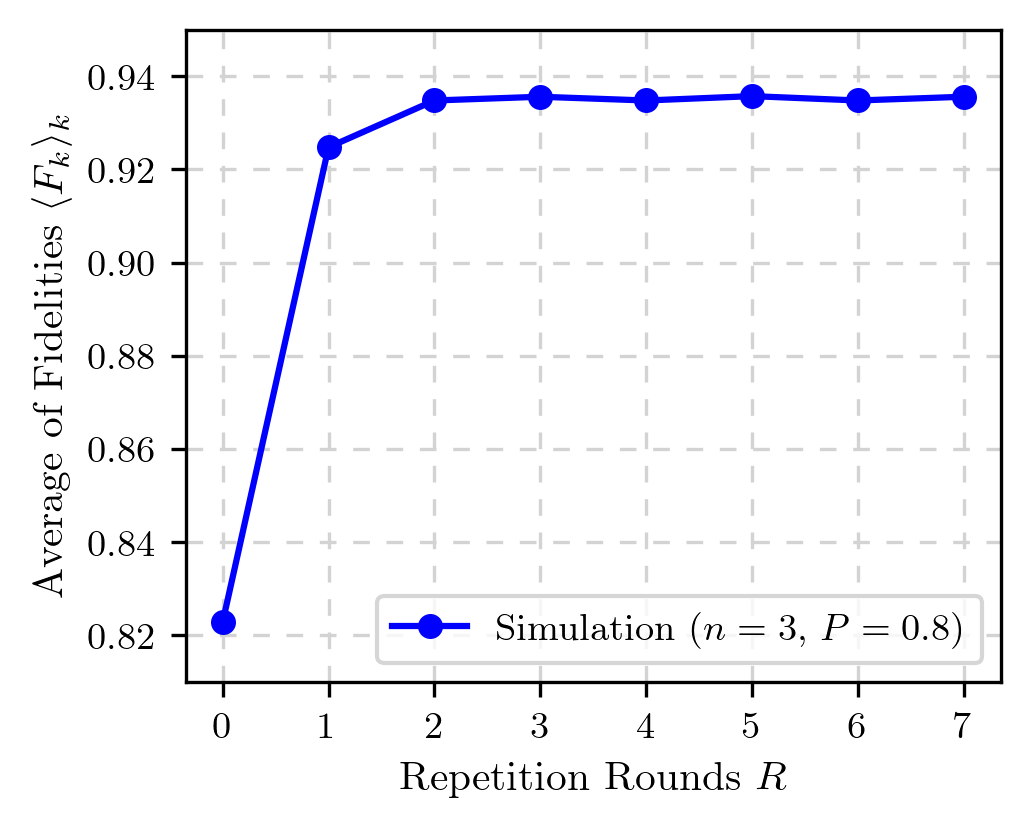

In [3]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Operator, DensityMatrix, state_fidelity
from typing import List, Dict, Tuple
import warnings
import time
import matplotlib as mpl
import matplotlib.pyplot as plt



APS_COLUMN_WIDTH_INCHES = 3.375

print("Setting up Matplotlib for publication quality...")
try:
    mpl.rcParams['text.usetex'] = True # <-- 启用 LaTeX
    mpl.rcParams['font.family'] = 'serif'
    mpl.rcParams['font.serif'] = ['Computer Modern Roman', 'Times New Roman']
    mpl.rcParams['xtick.labelsize'] = 9
    mpl.rcParams['ytick.labelsize'] = 9
    mpl.rcParams['axes.labelsize'] = 10
    mpl.rcParams['axes.titlesize'] = 10
    mpl.rcParams['legend.fontsize'] = 9
    mpl.rcParams['figure.dpi'] = 300
    print("  -> LaTeX rendering is ON.")
except Exception as e:
    print(f"  -> ERROR: Failed to enable LaTeX: {e}")
    print("     Falling back to standard fonts.")
    mpl.rcParams['text.usetex'] = False # 出错时回退


def build_U(n: int) -> QuantumCircuit:
    """构建 TSAC (U_TS) 酉电路"""
    qc = QuantumCircuit(n)
    if n == 1: return qc
    qc.x(n-1)
    for i in range(n-2, -1, -1):
        controls = list(range(i+1, n))
        qc.mcx(controls, i)
    if n > 1: qc.mcx(list(range(n-1)), n-1)
    qc.x(n-1)
    for i in range(n-1):
        controls = list(range(i+1, n))
        qc.mcx(controls, i)
    qc.x(n-1)
    decomposed_qc = transpile(qc, basis_gates=["cx", "sx", "rz"], optimization_level=0)
    return decomposed_qc

def extract_D_j_sets(circuit: QuantumCircuit) -> Dict[Tuple, List[QuantumCircuit]]:
    """extract Dj"""
    n_qubits = circuit.num_qubits
    D_j_sets = {}
    current_prefix_circuit = QuantumCircuit(n_qubits)
    qubit_to_index_map = {q: i for i, q in enumerate(circuit.qubits)}
    for instruction in circuit.data:
        gate = instruction.operation
        qargs = instruction.qubits
        if gate.name == 'cx':
            qubit_indices = [qubit_to_index_map[q] for q in qargs]
            qubit_tuple = tuple(sorted(qubit_indices))
            if qubit_tuple not in D_j_sets:
                D_j_sets[qubit_tuple] = []
            D_j_sets[qubit_tuple].append(current_prefix_circuit.copy())
        current_prefix_circuit.append(instruction)
    return D_j_sets

def get_initial_state(n_qubits: int, state_type: str = 'pure', p_ground: float = 0.95) -> DensityMatrix:
    """generate initial state"""
    d = 2**n_qubits
    if state_type == 'pure':
        print(f"  -> Using initial state: 'pure' (|0...0><0...0|)")
        rho_0_data = np.zeros((d, d), dtype=complex)
        rho_0_data[0, 0] = 1
        return DensityMatrix(rho_0_data)
    elif state_type == 'thermal':
        print(f"  -> Using initial state: 'thermal' (P(0)={p_ground})**(tensor n)")
        rho_1q_data = np.array([[p_ground, 0], [0, 1 - p_ground]], dtype=complex)
        rho_1q = DensityMatrix(rho_1q_data)
        rho_n = rho_1q
        for _ in range(n_qubits - 1):
            rho_n = rho_n.tensor(rho_1q)
        return rho_n
    else:
        raise ValueError("state_type must be 'pure' or 'thermal'")


def test_A6_avg_of_fidelities(n_qubits: int, initial_state_type: str, p_ground: float, num_rounds: int):
    """
    avg. of fidelities
    """
    print(f"--- n={n_qubits}, State='{initial_state_type}', p_ground={p_ground}, Rounds={num_rounds} | Test: Average of Fidelities (Eq. A6) ---")
    start_time_n = time.time()

    d = 2**n_qubits
    rho_0 = get_initial_state(n_qubits, initial_state_type, p_ground=p_ground) 
    rho_mixed = DensityMatrix(np.eye(d) / d)

    q_k = ( (d**2) / 4 - 1 ) / ( d**2 - 1 )
    rho_RHS = q_k * rho_0 + (1 - q_k) * rho_mixed

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=DeprecationWarning, module='qiskit.*')
        base_circuit = build_U(n_qubits)
        tsac_circuit = QuantumCircuit(n_qubits)
        for _ in range(num_rounds):
            tsac_circuit.compose(base_circuit, inplace=True)

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=DeprecationWarning)
        D_j_groups = extract_D_j_sets(tsac_circuit)

    total_fidelity = 0
    num_groups = 0

    possible_locations = []
    for i in range(n_qubits):
        for j in range(i + 1, n_qubits):
            possible_locations.append(tuple(sorted((i, j))))

    for location in possible_locations:
        circuit_list = D_j_groups.get(location, [])
        m_k = len(circuit_list)
        
        if num_rounds > 0 and m_k == 0:
            continue
            
        if m_k > 0:
            qc_noise = QuantumCircuit(n_qubits)
            qc_noise.cx(location[0], location[1])
            rho_LHS = DensityMatrix(np.zeros((d, d), dtype=complex))

            for D_j in circuit_list:
                D_j_dag = D_j.inverse()
                rho_1 = rho_0.evolve(D_j)
                rho_2 = rho_1.evolve(qc_noise)
                rho_3 = rho_2.evolve(D_j_dag)
                rho_LHS = rho_LHS + rho_3

            rho_LHS = rho_LHS / m_k
        else: 
            qc_noise = QuantumCircuit(n_qubits)
            qc_noise.cx(location[0], location[1])
            rho_LHS = rho_0.evolve(qc_noise)

        fidelity = state_fidelity(rho_LHS, rho_RHS)
        total_fidelity += fidelity
        num_groups += 1

    print(f"  -> Test complete. Time: {time.time() - start_time_n:.2f} sec")

    if num_groups > 0:
        avg_fidelity = total_fidelity / num_groups
        return avg_fidelity
    else:
        print("  -> ERROR: num_groups is 0. No CNOT locations found?")
        return None


if __name__ == "__main__":

    N_QUBITS = 3
    STATE_TYPE = 'thermal'
    P_GROUND = 0.8
    REPETITION_LIST = [0, 1, 2, 3, 4, 5, 6, 7]
    
    print("="*60)
    print(f"Starting Experiment: n={N_QUBITS}, State='{STATE_TYPE}', P(0)={P_GROUND}")
    print(f"Testing Repetition Rounds: {REPETITION_LIST}")
    print("="*60)

    results_A6_avg_of_fid = []

    for rounds in REPETITION_LIST:
        print(f"\n======= STARTING ROUNDS = {rounds} =======")
        f_micro = test_A6_avg_of_fidelities(
            n_qubits=N_QUBITS,
            initial_state_type=STATE_TYPE,
            p_ground=P_GROUND,
            num_rounds=rounds
        )
        results_A6_avg_of_fid.append(f_micro)

    print("\n\n" + "="*60)
    print("All experiment rounds complete.")
    print(f"Rounds: {REPETITION_LIST}")
    print(f"A6 (Avg. of Fidelities, Thermal, P(0)={P_GROUND}): {[round(f, 6) if f is not None else 'N/A' for f in results_A6_avg_of_fid]}")
    print("="*60)


    fig_width_in = APS_COLUMN_WIDTH_INCHES
    fig_height_in = fig_width_in * 0.8
    fig_size = (fig_width_in, fig_height_in)

    ylabel = r'Average of Fidelities $\langle F_k \rangle_k$'
    xlabel = r'Repetition Rounds $R$'
    pdf_filename = f'plot_A6_Fidelity_vs_Rounds_n3_P{P_GROUND}.pdf'

    print(f"Generating Plot ({pdf_filename})...")
    plt.figure(figsize=fig_size)
    

    plt.plot(REPETITION_LIST, results_A6_avg_of_fid,
             marker='o',
             markersize=5,
             linestyle='-',
             color='blue',
             label=r'Simulation ($n=3$, $P=0.8$)')

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    plt.grid(True, linestyle='--', color='lightgrey', dashes=(5, 5))
    
    plt.xticks(REPETITION_LIST)
    
    plt.ylim(0.81, 0.95)
    
    plt.legend(loc='lower right')
    
    
    plt.tight_layout(pad=0.5)
    
    plt.savefig(pdf_filename, bbox_inches='tight')
    print(f"  -> Saved '{pdf_filename}'")

    print("\nScript finished.")